In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
class NeuralNet:
    
    
    def __init__(self, normalize = True, learning_rate = 0.01, max_iter = 30000, hidden_layer_sizes=(100,), epsilon=1e-6):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
        self.n_layers = 1 + len(hidden_layer_sizes)
        self.epsilon = epsilon
        self.parameters = None
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)
    
    def __initialize_parameters(self, n_x, hidden_layers, n_y):
        np.random.seed(1)
        W = list()
        b = list()
        
        h = list(hidden_layers)
        h.insert(0, n_x)
        h.append(n_y)
        hidden_layers = tuple(h)
        
        for i in range(1, self.n_layers+1):
            W.append(np.random.randn(hidden_layers[i], hidden_layers[i-1]) * 0.01)
            b.append(np.zeros((hidden_layers[i], 1)))

        self.parameters = {"W" : W, "b" : b}
    
    def __forward_propagation(self, X):
        W = self.parameters["W"]
        b = self.parameters["b"]

        A = list()
        Z = list()
               
        for i in range(0, self.n_layers-1):
            if i == 0:
                Z.append(np.dot(W[i], X) + b[i])
            else:
                Z.append(np.dot(W[i], A[i-1]) + b[i])
            A.append(self.__sigmoid(Z[i]))
        
        Z.append(np.dot(W[-1], A[-1]) + b[-1])
        A.append(self.softmax(Z[-1]))
        
        cache = (W, b, Z, A)

        return A[-1], cache
    
    def __sigmoid_derivative(self, Z):
        s = 1 / (1 + np.exp(-Z))
        return np.multiply(s, (1 - s))
    
    def cross_entropy(self, A, Y):
        return - np.sum(np.log(A) * (Y), axis=1)
    
    def compute_cost(self, A, Y):
        J = -np.mean(Y.T * np.log(A.T+ 1e-8))
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W, b, Z, A) = cache
        
        dW = [None] * (self.n_layers)
        dA = [None] * (self.n_layers)
        dZ = [None] * (self.n_layers)
        db = [None] * (self.n_layers)
        
        dZ[-1] = (A[-1] - Y)
        dW[-1] = (1. / m * np.dot(dZ[-1], A[-2].T))
        db[-1] = (1. / m * np.sum(dZ[-1], axis = 1, keepdims = True))
        dA[-1] = np.dot(W[-1].T, dZ[-1])
        
        for i in range(self.n_layers-1, 0, -1):
            dZ[i-1] = np.multiply(dA[i], self.__sigmoid_derivative(Z[i-1]))
            if i-1 == 0:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], X.T)
            else:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], A[i-2].T)
            db[i-1] = 1. / m * np.sum(dZ[i-1], axis = 1, keepdims = True) 
            dA[i-1] = np.dot(W[i-1].T, dZ[i-1])
        
        grads = {"dZ" : dZ, "dW" : dW, "db" : db}
        return grads
    
    def __update_parameters(self, grads):
        W = self.parameters["W"]
        b = self.parameters["b"]

        dW = grads["dW"]
        db = grads["db"]
        
        for i in range(self.n_layers):
            W[i] = W[i] - self.learning_rate * dW[i]
            b[i] = b[i] - self.learning_rate * db[i]

    def fit(self, X_vert, Y_vert, print_cost = True):
        self.n_iter = 0
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        cost_history = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        n_y = Y.shape[0]
        
        self.__initialize_parameters(n_x, self.hidden_layer_sizes, n_y)

        for i in range(self.max_iter):
            self.n_iter = i
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)
            cost_history.append(cost)
            
            grads = self.__backward_propagation(X, Y, cache)
            self.__update_parameters(grads)
            
            
            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)
  
            if i > 1 and abs(cost-cost_history[-2]) < self.epsilon:
                break

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *100")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return probs.T
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        y_pred = self.to_classlabel(positive_probs)
        return y_pred  

    def to_classlabel(self, z):
        return z.argmax(axis=1)

In [3]:
from sklearn import datasets
iris = datasets.load_iris()

X = iris.data
Y = iris.target.reshape((X.shape[0], 1))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True)

print(type(y_train))
print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

<class 'numpy.ndarray'>
Training set: X=(120, 4), y=(120, 1)
Test set: X=(30, 4), y=(30, 1)


In [5]:
y_train = to_categorical(y_train)
y_train.shape

(120, 3)

0-th iteration: 0.36594461343406565
1000-th iteration: 0.04133781548403443
2000-th iteration: 0.02763669487658609
3000-th iteration: 0.023992516192302905
4000-th iteration: 0.022276030855111133


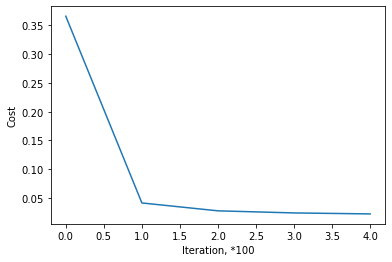

In [6]:
cls = NeuralNet(normalize = False, learning_rate = 0.1, max_iter = 30000, hidden_layer_sizes=(50,), epsilon=1e-6)
cls.fit(X_train, y_train, print_cost=True)

In [7]:
print(cls.parameters)

{'W': [array([[-0.16401071, -0.32364876,  0.53224903,  0.41920188],
       [ 0.13735792,  0.07435653, -0.29566204, -0.42699008],
       [ 0.09693972,  0.09551592, -0.27641005, -0.37953287],
       [ 0.49578903,  0.45432519, -0.77578561, -1.00661363],
       [-0.16023596, -0.327089  ,  0.53580232,  0.41167721],
       [-0.38988325, -0.49177151,  0.79819164,  0.76964486],
       [-0.17643625, -0.39476049,  0.61594049,  0.43178297],
       [ 0.34824668,  0.34553627, -0.61999465, -0.74590003],
       [ 0.02940097, -0.07808117,  0.21881522,  0.13726044],
       [ 0.32210286,  0.36606368, -0.61787464, -0.70791445],
       [-0.13121133, -0.25962224,  0.44867383,  0.38253727],
       [-0.30283745, -0.44885339,  0.70750773,  0.65781707],
       [ 0.06671691,  0.06823744, -0.24622214, -0.32310664],
       [ 0.26435853,  0.27621352, -0.52254692, -0.60532724],
       [-0.43650812, -0.55306747,  0.85289053,  0.86823027],
       [ 0.17818031,  0.20252259, -0.40524028, -0.49045442],
       [-0.245362

In [8]:
Y_prob = cls.predict_proba(X_test)
Y_prob

array([[1.70122343e-07, 3.20378249e-02, 9.67962005e-01],
       [1.06781363e-11, 4.77273974e-05, 9.99952273e-01],
       [9.94501896e-01, 5.49810379e-03, 7.22056358e-16],
       [9.94730056e-01, 5.26994430e-03, 6.69640510e-16],
       [9.98300518e-01, 1.69948230e-03, 3.29772179e-17],
       [2.43930946e-04, 9.91241443e-01, 8.51462640e-03],
       [9.95338631e-01, 4.66136943e-03, 5.26525551e-16],
       [7.09412848e-04, 9.98271542e-01, 1.01904498e-03],
       [9.97894257e-01, 2.10574276e-03, 6.04836891e-17],
       [9.98019135e-01, 1.98086493e-03, 4.83843697e-17],
       [9.96412694e-01, 3.58730624e-03, 2.54348859e-16],
       [7.41630609e-10, 7.76951685e-04, 9.99223048e-01],
       [9.96681107e-01, 3.31889342e-03, 1.76982864e-16],
       [1.78435051e-07, 3.39900852e-02, 9.66009736e-01],
       [9.97756137e-01, 2.24386310e-03, 7.65496725e-17],
       [1.70562563e-03, 9.98138253e-01, 1.56121286e-04],
       [6.62192006e-09, 3.32625500e-03, 9.96673738e-01],
       [9.97220163e-01, 2.77983

In [9]:
Y_hat = cls.predict(X_test)

In [10]:
accuracy_score(y_test, Y_hat)

1.0

In [11]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,10), max_iter = 11000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.001, learning_rate = 'constant')

In [12]:
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 10), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=11000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [13]:
Y_pred = clf.predict(X_test)

accuracy_score(to_categorical(y_test), Y_pred)

1.0